# Gram Matrices for Style (Neural Style Transfer) — Visual Demo

This notebook builds the **first part** of the larger demo:
**Load 4 images → run a fixed pretrained CNN → compute Gram matrices at selected layers → sanity-check everything.**

Planned later (not yet in this part):
- Pairwise similarity (cosine / L2) on style embeddings
- PCA “downsampling” of Gram matrices for visualization
- A distance heatmap across images

---

## What you provide
Set the 4 URLs in the next cell:
- 2 images from “Style A” (e.g., Van Gogh)
- 2 images from “Style B” (e.g., animation / Disney-like)

**Tip:** Keep images reasonably sized (≤ 2000px wide). We'll resize anyway.


In [1]:
# -------------------------
# Required utility: load_image(url)
from io import BytesIO
import requests
from PIL import Image

from sklearn.decomposition import PCA



def load_image(url):
    '''Downloads and returns a PIL image from the given URL.'''
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise ValueError(f"Failed to download image: {url}")
    try:
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        raise ValueError(f"Could not open image from {url}. Error: {e}")
# -------------------------

# Sanity
assert callable(load_image)


In [2]:
# Provide your 4 image URLs here
URLS = {
    "vangogh_1": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/960px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",
    "vangogh_2": "https://cdn.kastatic.org/ka-perseus-images/653f09fedc305ad96ff0f7272df19fa7624f3c7e.jpg",
    # "disney_1":  "https://assets.teenvogue.com/photos/5ce81c56b68fa25979a033a9/16:9/w_1280,c_limit/Aladdin-Featured-11182017.jpg",
    # "disney_2":  "https://www.hollywoodreporter.com/wp-content/uploads/2018/07/aladdin_still.jpg?w=1296&h=730&crop=1",
    # "disney_2":  "https://d23.com/app/uploads/2015/10/1180w-600h_aladdin-diamond-edition-1180x600.jpg",
    "disney_1":  "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg",
    "disney_2":  "https://cdn.pixabay.com/photo/2024/02/28/07/42/european-shorthair-8601492_640.jpg",


    
}

# Sanity
assert isinstance(URLS, dict) and len(URLS) == 4
for k, v in URLS.items():
    assert isinstance(k, str) and isinstance(v, str)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torchvision.models import vgg19, VGG19_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# Sanity
assert device in ("cuda", "cpu")


device: cuda


In [4]:
def assert_tensor(t: torch.Tensor, *, shape=None, finite=True, name="tensor"):
    assert isinstance(t, torch.Tensor), f"{name} is not a torch.Tensor"
    if shape is not None:
        assert tuple(t.shape) == tuple(shape), f"{name}.shape={tuple(t.shape)} expected={tuple(shape)}"
    if finite:
        assert torch.isfinite(t).all().item(), f"{name} contains non-finite values"

def assert_symmetric_psd(G: torch.Tensor, *, tol_sym=1e-5, tol_eig=1e-6, name="G"):
    """For a true Gram matrix: symmetric, PSD. Small negative eigenvalues may occur due to float error."""
    assert_tensor(G, name=name)
    assert G.ndim == 2 and G.shape[0] == G.shape[1], f"{name} must be square"
    sym_err = (G - G.T).abs().max().item()
    assert sym_err < tol_sym, f"{name} not symmetric enough: max|G-G^T|={sym_err}"
    Gcpu = G.detach().cpu()
    eigvals = torch.linalg.eigvalsh(Gcpu)
    min_eig = eigvals.min().item()
    assert min_eig >= -tol_eig, f"{name} not PSD within tolerance: min_eig={min_eig}"
    assert (torch.diag(Gcpu) >= -tol_eig).all().item(), f"{name} has negative diagonal entries"

tmp = torch.eye(4)
assert_symmetric_psd(tmp, name="I4")


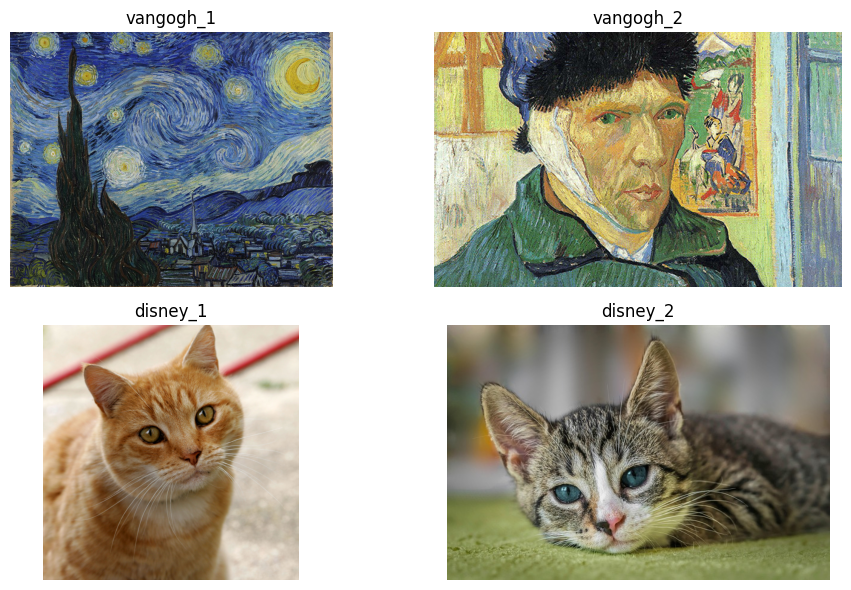

In [5]:
# Load the 4 images
imgs_pil = {k: load_image(u) for k, u in URLS.items()}

# Show them
plt.figure(figsize=(10, 6))
for i, (k, im) in enumerate(imgs_pil.items(), start=1):
    plt.subplot(2, 2, i)
    plt.imshow(im)
    plt.title(k)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Sanity
assert len(imgs_pil) == 4
for k, im in imgs_pil.items():
    assert hasattr(im, "size")
    w, h = im.size
    assert w > 10 and h > 10


## Fixed pretrained model

We use a fixed pretrained **VGG-19** (features only).
No training. No finetuning. We compute feature maps and Gram matrices.


In [6]:
weights = VGG19_Weights.DEFAULT
vgg = vgg19(weights=weights).features.to(device).eval()
for p in vgg.parameters():
    p.requires_grad_(False)

IMG_SIZE = 256
preprocess = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

# Sanity
assert isinstance(vgg, nn.Module)


## Choose layers for "style"

We pick layer indices from `vgg.features` corresponding to ReLU outputs.
We verify shapes rather than rely on layer-name assumptions.


In [7]:
LAYER_IDS = [1, 6, 11, 20]

# Sanity
assert all(isinstance(i, int) for i in LAYER_IDS)
assert len(set(LAYER_IDS)) == len(LAYER_IDS)


In [8]:
def pil_to_tensor(im_pil):
    x = preprocess(im_pil).unsqueeze(0)  # (1,3,H,W)
    return x.to(device)

def extract_features(x: torch.Tensor, layer_ids=LAYER_IDS):
    feats = {}
    h = x
    for i, layer in enumerate(vgg):
        h = layer(h)
        if i in layer_ids:
            feats[i] = h
    return feats

features = {}
for name, im in imgs_pil.items():
    x = pil_to_tensor(im)
    feats = extract_features(x)
    features[name] = feats

# Sanity
for name in features:
    feats = features[name]
    assert set(feats.keys()) == set(LAYER_IDS), f"{name} missing layers"
    for lid, act in feats.items():
        assert act.ndim == 4 and act.shape[0] == 1, f"{name} layer {lid} bad shape {tuple(act.shape)}"
        assert_tensor(act, name=f"act[{name}][{lid}]")


## Gram matrix

For a feature map $A \in \mathbb{R}^{1 \times C \times H \times W}$:

1. Flatten spatial dims: $F \in \mathbb{R}^{C \times N}$, where $N = HW$
2. Gram: $G = FF^T \in \mathbb{R}^{C \times C}$

We normalize by **(C·H·W)** so layers don't dominate only due to size.


In [9]:
def gram_matrix(act: torch.Tensor, normalize=True) -> torch.Tensor:
    assert act.ndim == 4 and act.shape[0] == 1
    _, C, H, W = act.shape
    F = act[0].reshape(C, H * W)   # (C, N)
    G = F @ F.t()                 # (C, C)
    if normalize:
        G = G / (C * H * W)
    return G

grams = {}
for name in features:
    grams[name] = {}
    for lid, act in features[name].items():
        G = gram_matrix(act, normalize=True).detach().cpu()
        grams[name][lid] = G

# Sanity
for name in grams:
    for lid, G in grams[name].items():
        assert_symmetric_psd(G, name=f"G[{name}][{lid}]")


## Visual sanity check (small layer)

Gram matrices get huge in deeper layers.
We visualize an early layer where the heatmap is readable.


Visualizing layer 1 with C = 64


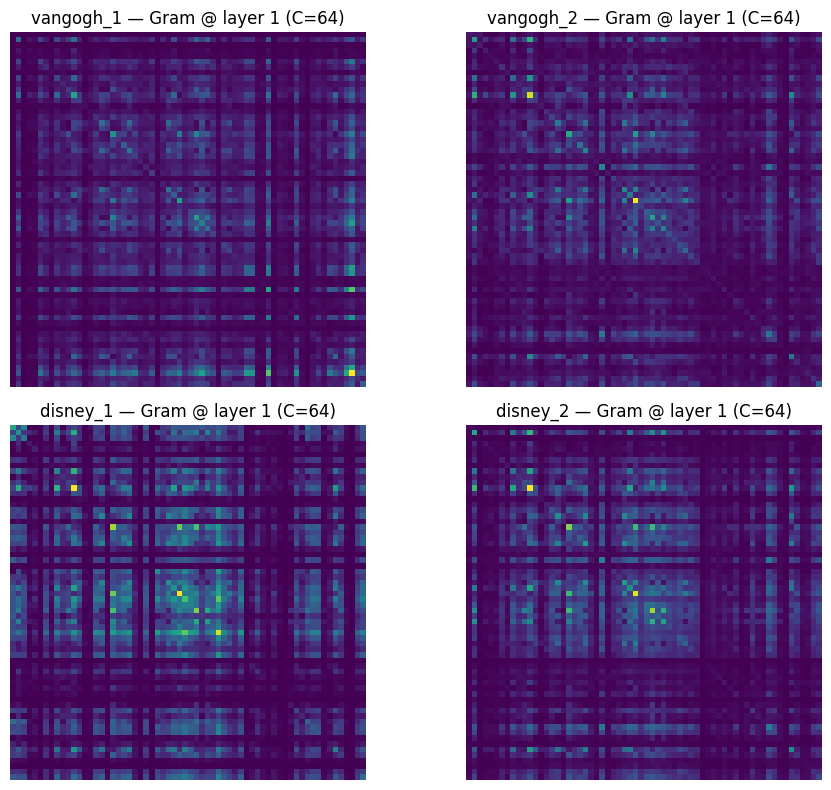

In [10]:
viz_lid = LAYER_IDS[0]
C = next(iter(grams.values()))[viz_lid].shape[0]
print("Visualizing layer", viz_lid, "with C =", C)
assert C <= 128, "Pick an early layer with <=128 channels for readability."

plt.figure(figsize=(10, 8))
for i, (name, d) in enumerate(grams.items(), start=1):
    G = d[viz_lid].numpy()
    plt.subplot(2, 2, i)
    plt.imshow(G)
    plt.title(f"{name} — Gram @ layer {viz_lid} (C={G.shape[0]})")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Note (for later): explicit layer weights

Two separate choices:

1. **Gram normalization** by size (we already do this): divides by $C \cdot H \cdot W$.
   This is about fair scaling and stable gradients.

2. **Layer weights** $w_\ell$ in the final style loss:
$\mathcal{L}_{style} = \sum_\ell w_\ell \|G_\ell^{gen} - G_\ell^{style}\|^2$

Where do $w_\ell$ come from?
- Many references use **uniform** weights (all 1’s).
- Others hand-tune weights to emphasize fine texture (early layers) vs larger motifs (mid layers).
- For teaching: treat weights as a **preference knob**, not a constant derived from theory.

We'll keep it simple later (uniform weights), and optionally add an interactive slider to explore the effect.


In [11]:
# End-of-part checkpoint: what we have so far

print("Images:", list(imgs_pil.keys()))
print("Layers:", LAYER_IDS)
for name in grams:
    for lid in LAYER_IDS:
        G = grams[name][lid]
        print(f"{name:10s} layer {lid:2d} Gram shape:", tuple(G.shape))

# Sanity: all PSD
assert len(grams) == 4
for name in grams:
    assert set(grams[name].keys()) == set(LAYER_IDS)
    for lid in LAYER_IDS:
        assert_symmetric_psd(grams[name][lid], name=f"G[{name}][{lid}]")

print("\n✅ Part 1 complete: Gram matrices computed and sanity-checked.")


Images: ['vangogh_1', 'vangogh_2', 'disney_1', 'disney_2']
Layers: [1, 6, 11, 20]
vangogh_1  layer  1 Gram shape: (64, 64)
vangogh_1  layer  6 Gram shape: (128, 128)
vangogh_1  layer 11 Gram shape: (256, 256)
vangogh_1  layer 20 Gram shape: (512, 512)
vangogh_2  layer  1 Gram shape: (64, 64)
vangogh_2  layer  6 Gram shape: (128, 128)
vangogh_2  layer 11 Gram shape: (256, 256)
vangogh_2  layer 20 Gram shape: (512, 512)
disney_1   layer  1 Gram shape: (64, 64)
disney_1   layer  6 Gram shape: (128, 128)
disney_1   layer 11 Gram shape: (256, 256)
disney_1   layer 20 Gram shape: (512, 512)
disney_2   layer  1 Gram shape: (64, 64)
disney_2   layer  6 Gram shape: (128, 128)
disney_2   layer 11 Gram shape: (256, 256)
disney_2   layer 20 Gram shape: (512, 512)

✅ Part 1 complete: Gram matrices computed and sanity-checked.


# Gram Matrices for Style — Part 2: Shared PCA + Style Embeddings + Similarity

**Prerequisite:** Run Part 1 so these variables exist:
- `grams` : dict[name][layer_id] -> Gram matrix (torch.Tensor on CPU)
- `LAYER_IDS` : list of selected layer indices
- `assert_tensor`, `assert_symmetric_psd` : sanity helpers (optional)

This part builds:
1. A **shared PCA basis** per layer (row-wise PCA on Gram rows)
2. Per-image **style embeddings** `z_i`
3. Pairwise **similarity / distance matrices** (cosine + L2)
4. Visualizations: distance heatmaps and 2D scatter (PCA-on-embeddings)

We keep the story simple:
- **No hand-tuned layer weights** here (we start with equal contribution).
- Later, you can add a slider for layer weights as a *preference knob*.


In [12]:
# Sanity: check Part 1 outputs exist
required = ['grams', 'LAYER_IDS']
for name in required:
    assert name in globals(), f"Missing `{name}`. Run Part 1 first."

assert isinstance(grams, dict) and len(grams) == 4
assert isinstance(LAYER_IDS, list) and len(LAYER_IDS) >= 1

img_names = list(grams.keys())
print('Images:', img_names)
print('Layers:', LAYER_IDS)

# Sanity: each image has every layer
for n in img_names:
    assert set(grams[n].keys()) == set(LAYER_IDS)

# Sanity: Gram shapes align across images
for lid in LAYER_IDS:
    shapes = [tuple(grams[n][lid].shape) for n in img_names]
    assert len(set(shapes)) == 1, f"Layer {lid} has inconsistent shapes: {shapes}"


Images: ['vangogh_1', 'vangogh_2', 'disney_1', 'disney_2']
Layers: [1, 6, 11, 20]


In [13]:
# Sanity
assert PCA is not None

## Step 1 — Row-wise PCA per layer (shared basis)

For each layer:

- Each Gram matrix is **C×C**
- Each **row** is a vector in **ℝ^C**: 'correlation fingerprint of one channel'
- We stack rows from all images: **(M·C)×C**
- Fit **one shared PCA**: ℝ^C → ℝ^K
- Transform each image’s rows → **C×K**

Then we aggregate rows (mean over channels) to get a **single per-image embedding**:

- `z_by_layer[lid][name]` has shape **(K,)**

This gives a clean 'style embedding' per image per layer.


In [14]:
K = 16  # target embedding dimension per layer

# Sanity
assert isinstance(K, int) and K > 0

def rowwise_pca_embeddings_for_layer(grams_by_img: dict, layer_id: int, K: int):
    '''
    grams_by_img: dict[name] -> Gram (C,C) torch tensor (CPU)
    Returns:
      pca: fitted PCA
      Z_rows: dict[name] -> (C,K) torch tensor (CPU)
      z_img: dict[name] -> (K,) torch tensor (CPU), mean over rows
    '''
    names = list(grams_by_img.keys())
    G0 = grams_by_img[names[0]]
    assert isinstance(G0, torch.Tensor) and G0.ndim == 2 and G0.shape[0] == G0.shape[1]
    C = G0.shape[0]

    # Stack all rows from all images: (M*C, C)
    X = []
    for n in names:
        G = grams_by_img[n]
        assert tuple(G.shape) == (C, C), f"{n} layer {layer_id} bad shape {tuple(G.shape)}"
        X.append(G.numpy())  # (C,C), rows are samples
    X = np.concatenate(X, axis=0)  # (M*C, C)

    # Fit shared PCA on rows
    pca = PCA(n_components=min(K, C), whiten=False, random_state=0)
    Xk = pca.fit_transform(X)  # (M*C, K)

    # Unstack back per image → (C,K)
    Z_rows = {}
    z_img = {}
    start = 0
    for n in names:
        Zi = Xk[start:start+C, :]  # (C,K)
        start += C
        Zi_t = torch.tensor(Zi, dtype=torch.float32)
        Z_rows[n] = Zi_t
        z_img[n] = Zi_t.mean(dim=0)  # (K,)
    assert start == X.shape[0]

    return pca, Z_rows, z_img

# Build per-layer PCA + embeddings
pca_by_layer = {}
Zrows_by_layer = {}
z_by_layer = {}

for lid in LAYER_IDS:
    grams_layer = {n: grams[n][lid] for n in img_names}
    pca, Z_rows, z_img = rowwise_pca_embeddings_for_layer(grams_layer, lid, K)
    pca_by_layer[lid] = pca
    Zrows_by_layer[lid] = Z_rows
    z_by_layer[lid] = z_img

# Sanity: shapes
for lid in LAYER_IDS:
    C = grams[img_names[0]][lid].shape[0]
    for n in img_names:
        assert Zrows_by_layer[lid][n].shape == (C, min(K, C))
        assert z_by_layer[lid][n].shape == (min(K, C),)

print('✅ Row-wise PCA embeddings computed per layer.')


✅ Row-wise PCA embeddings computed per layer.


## Step 2 — Combine layers into a single style embedding (optional)

You now have:
- per-layer embedding: `z_by_layer[lid][name]`  → shape `(K,)`

Two simple ways to combine layers:

### A) Concatenate (keeps information)
$z^{(all)} = [z^{(l_1)} \;|\; z^{(l_2)} \;|\; ...]$  → shape `(K·L,)`

### B) Mean across layers (keeps dimension K)
Good for quick demos, but loses some nuance.

We’ll do **both** and compare.


In [15]:
# Build combined embeddings
z_concat = {}  # name -> (K*L,)
z_mean = {}    # name -> (K,)

for n in img_names:
    zs = [z_by_layer[lid][n] for lid in LAYER_IDS]  # list of (K,)
    Z = torch.stack(zs, dim=0)                      # (L,K)
    z_mean[n] = Z.mean(dim=0)                       # (K,)
    z_concat[n] = Z.reshape(-1)                     # (L*K,)

# Sanity
K_eff = z_mean[img_names[0]].shape[0]
for n in img_names:
    assert z_mean[n].shape == (K_eff,)
    assert z_concat[n].shape == (len(LAYER_IDS) * K_eff,)

print('K per layer:', K_eff)
print('Concat dim:', z_concat[img_names[0]].shape[0])


K per layer: 16
Concat dim: 64


## Step 3 — Similarity / distance matrices

Two useful choices:
- **Cosine distance**: compares direction (pattern) ignoring scale
- **L2 distance**: compares absolute difference (pattern + scale)

For style embeddings, cosine is usually the best 'first' metric.
We’ll compute both and plot heatmaps.


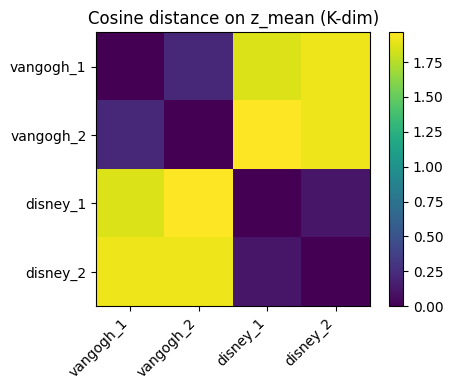

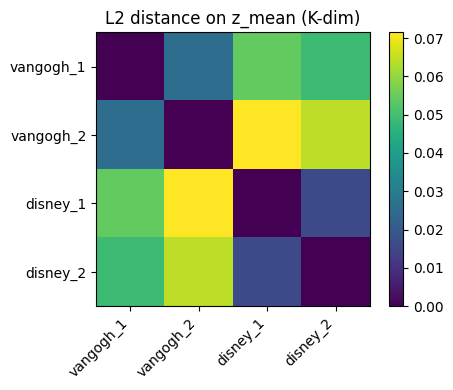

In [16]:
def cosine_distance(a: torch.Tensor, b: torch.Tensor, eps=1e-12) -> float:
    a = a.float()
    b = b.float()
    num = torch.dot(a, b).item()
    den = (a.norm().item() * b.norm().item()) + eps
    cos_sim = num / den
    return float(1.0 - cos_sim)

def l2_distance(a: torch.Tensor, b: torch.Tensor) -> float:
    return float(torch.norm(a - b, p=2).item())

def pairwise_distance_matrix(emb: dict, dist_fn):
    names = list(emb.keys())
    n = len(names)
    D = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            D[i, j] = dist_fn(emb[names[i]], emb[names[j]])
    return names, D

def plot_heatmap(D, labels, title):
    plt.figure(figsize=(5, 4))
    plt.imshow(D)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Compute on mean embedding
labels, D_cos = pairwise_distance_matrix(z_mean, cosine_distance)
_,      D_l2  = pairwise_distance_matrix(z_mean, l2_distance)

# Sanity: diagonals near 0
assert np.allclose(np.diag(D_cos), 0, atol=1e-6)
assert np.allclose(np.diag(D_l2), 0, atol=1e-6)

plot_heatmap(D_cos, labels, 'Cosine distance on z_mean (K-dim)')
plot_heatmap(D_l2,  labels, 'L2 distance on z_mean (K-dim)')


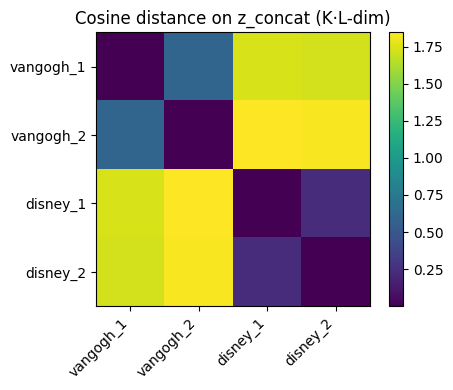

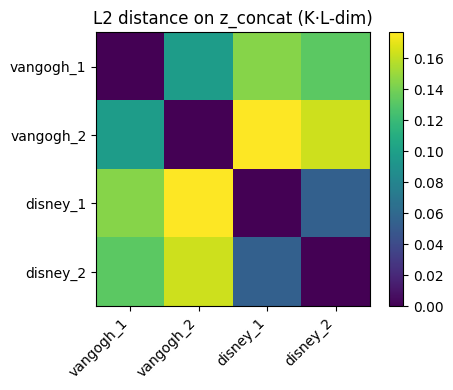

In [17]:
# Compute on concatenated embedding too (more info kept)
labels2, D2_cos = pairwise_distance_matrix(z_concat, cosine_distance)
_,       D2_l2  = pairwise_distance_matrix(z_concat, l2_distance)

assert labels2 == labels  # same ordering

plot_heatmap(D2_cos, labels2, 'Cosine distance on z_concat (K·L-dim)')
plot_heatmap(D2_l2,  labels2, 'L2 distance on z_concat (K·L-dim)')


In [18]:
print("Van Gogh ↔ Van Gogh:", D2_cos[0,1])
print("Disney   ↔ Disney  :", D2_cos[2,3])
print("Cross-style mean   :", 
      np.mean([D2_cos[i,j] for i in [0,1] for j in [2,3]]))


Van Gogh ↔ Van Gogh: 0.6033884
Disney   ↔ Disney  : 0.2328411
Cross-style mean   : 1.7805785


## Step 4 — 2D visualization (PCA on embeddings)

This is **only for visualization**.
Distances in the full embedding space are the primary evidence.

We project embeddings to 2D with PCA and plot points.


In [19]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# # -----------------------------
# # Choose visualization method
# # -----------------------------
# VIS_METHOD = "tsne"   # options: "pca", "tsne"

# # -----------------------------
# # Prepare data
# # -----------------------------
# names = list(z_concat.keys())
# X = np.stack([z_concat[n].numpy() for n in names], axis=0)  # (M, D)

# assert X.ndim == 2 and X.shape[0] == len(names)

# # -----------------------------
# # Compute 2D projection
# # -----------------------------
# if VIS_METHOD == "pca":
#     reducer = PCA(n_components=2, random_state=0)
#     XY = reducer.fit_transform(X)
#     extra_info = f"Explained variance ratio: {reducer.explained_variance_ratio_}"

# elif VIS_METHOD == "tsne":
#     reducer = TSNE(
#         n_components=2,
#         perplexity=min(3, len(names) - 1),  # safe for tiny datasets
#         init="pca",
#         learning_rate="auto",
#         random_state=0,
#     )
#     XY = reducer.fit_transform(X)
#     extra_info = "t-SNE: distances are NOT metric-preserving"

# else:
#     raise ValueError("VIS_METHOD must be 'pca' or 'tsne'")

# # -----------------------------
# # Plot
# # -----------------------------
# plt.figure(figsize=(6, 5))
# for i, n in enumerate(names):
#     plt.scatter(XY[i, 0], XY[i, 1])
#     plt.text(XY[i, 0] + 0.01, XY[i, 1] + 0.01, n)

# title = f"2D {VIS_METHOD.upper()} projection of z_concat (visualization only)"
# plt.title(title)
# plt.xlabel("dim 1")
# plt.ylabel("dim 2")
# plt.tight_layout()
# plt.show()

# print(extra_info)

# # -----------------------------
# # Sanity
# # -----------------------------
# assert XY.shape == (len(names), 2)
# assert np.isfinite(XY).all()


## Step 5 — Optional: layer-by-layer distance heatmaps

Sometimes style separation shows up strongly in early layers; sometimes mid layers.
Here we compute cosine distances per layer for quick diagnosis.


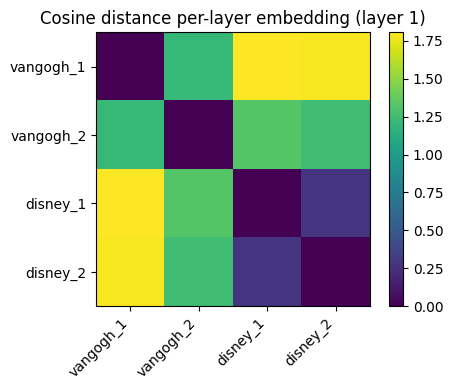

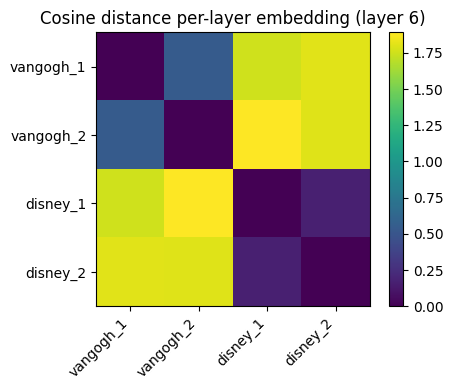

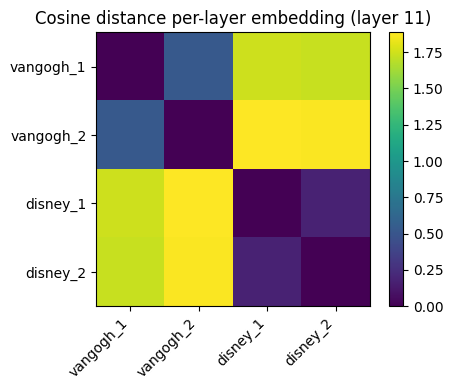

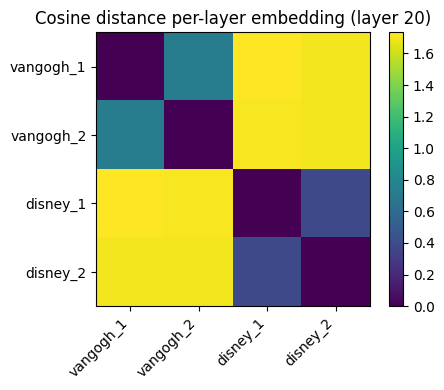

✅ Part 2 complete: embeddings + similarity visualizations.


In [20]:
for lid in LAYER_IDS:
    emb = {n: z_by_layer[lid][n] for n in img_names}
    labels_l, D_l = pairwise_distance_matrix(emb, cosine_distance)
    assert labels_l == img_names
    plot_heatmap(D_l, labels_l, f'Cosine distance per-layer embedding (layer {lid})')

print('✅ Part 2 complete: embeddings + similarity visualizations.')


# Part 3 — Backprop Into The Input (Sanity → One Step → Morph)

## Key idea:
## - CNN is frozen
## - image pixels are the variables
## - we backprop the loss into the pixels


In [21]:
import ipywidgets as widgets
from IPython.display import display

# Shared ipywidgets slider style/layout
SLIDER_STYLE  = {'description_width': '160px'}   # enough space for labels
SLIDER_LAYOUT = widgets.Layout(width='520px')    # consistent overall width

assert isinstance(SLIDER_STYLE, dict)


In [22]:
def show_image(img, title=None):
    """img: torch (3,H,W) in [0,1] on CPU"""
    assert isinstance(img, torch.Tensor) and img.ndim == 3 and img.shape[0] == 3
    assert torch.isfinite(img).all().item()
    x = img.permute(1,2,0).numpy()
    x = np.clip(x, 0, 1)
    plt.imshow(x)
    if title:
        plt.title(title)
    plt.axis("off")

def assert_tensor(t, *, ndim=None, finite=True, name="tensor"):
    assert isinstance(t, torch.Tensor), f"{name} not a torch.Tensor"
    if ndim is not None:
        assert t.ndim == ndim, f"{name}.ndim={t.ndim}, expected {ndim}"
    if finite:
        assert torch.isfinite(t).all().item(), f"{name} has non-finite values"

def gram_matrix(act: torch.Tensor, normalize=True) -> torch.Tensor:
    # act: (1,C,H,W)
    assert_tensor(act, ndim=4, name="act")
    assert act.shape[0] == 1
    _, C, H, W = act.shape
    F = act[0].reshape(C, H*W)      # (C,N)
    G = F @ F.t()                  # (C,C)
    if normalize:
        G = G / (C * H * W)
    return G

# sanity
tmp = torch.rand(1, 8, 4, 4)
G = gram_matrix(tmp)
assert G.shape == (8, 8)
assert torch.allclose(G, G.T, atol=1e-5)


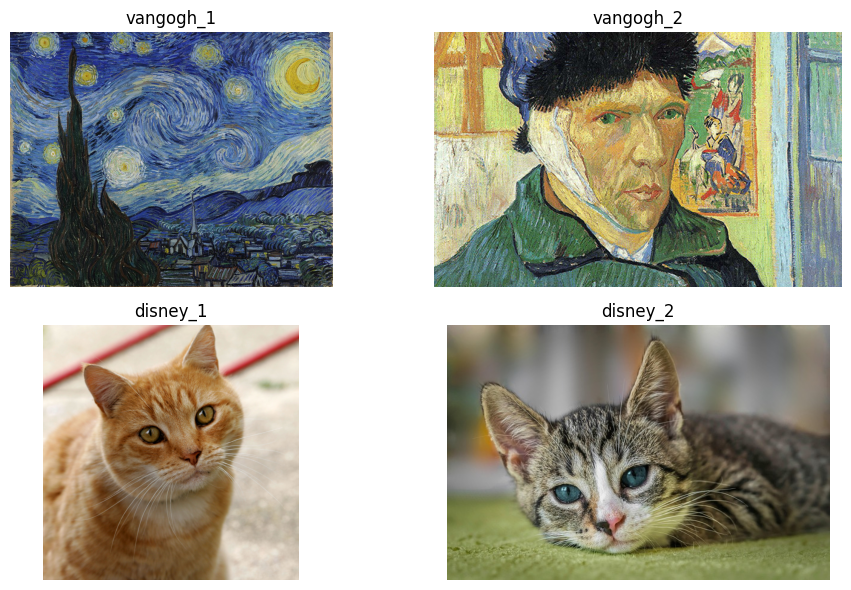

In [23]:
imgs_pil = {k: load_image(u) for k, u in URLS.items()}

plt.figure(figsize=(10,6))
for i, (k, im) in enumerate(imgs_pil.items(), start=1):
    plt.subplot(2,2,i)
    plt.imshow(im)
    plt.title(k)
    plt.axis("off")
plt.tight_layout()
plt.show()

assert len(imgs_pil) == 4
for k, im in imgs_pil.items():
    w, h = im.size
    assert w > 10 and h > 10


In [24]:
weights = VGG19_Weights.DEFAULT
vgg = vgg19(weights=weights).features.to(device).eval()
for p in vgg.parameters():
    p.requires_grad_(False)

IMG_SIZE = 256

to_tensor_01 = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),            # -> [0,1]
])

mean = torch.tensor(weights.transforms().mean).view(1,3,1,1).to(device)
std  = torch.tensor(weights.transforms().std ).view(1,3,1,1).to(device)

def normalize(x01: torch.Tensor) -> torch.Tensor:
    # x01: (1,3,H,W) in [0,1]
    return (x01 - mean) / std

assert isinstance(vgg, nn.Module)


In [25]:
# VGG feature indices
CONTENT_LID = 20
# STYLE_LIDS  = [1, 6, 11, 20]
STYLE_LIDS = [1, 6, 11, 20]

STYLE_LAYER_WEIGHTS = {
    1: 0.6,
    6: 0.8,
    11: 1.0,
    20: 0.8,
}

assert isinstance(CONTENT_LID, int)
assert all(isinstance(i, int) for i in STYLE_LIDS) and len(STYLE_LIDS) > 0


In [26]:
def extract_acts(x01: torch.Tensor, layer_ids):
    """x01: (1,3,H,W) in [0,1]"""
    assert_tensor(x01, ndim=4, name="x01")
    assert x01.shape[0] == 1 and x01.shape[1] == 3
    x = normalize(x01)
    acts = {}
    h = x
    for i, layer in enumerate(vgg):
        h = layer(h)
        if i in layer_ids:
            acts[i] = h
    return acts

# sanity
x_test = to_tensor_01(imgs_pil["disney_1"]).unsqueeze(0).to(device)
acts = extract_acts(x_test, set([CONTENT_LID] + STYLE_LIDS))
assert set([CONTENT_LID] + STYLE_LIDS).issubset(set(acts.keys()))


Content: disney_1 | Style: vangogh_1


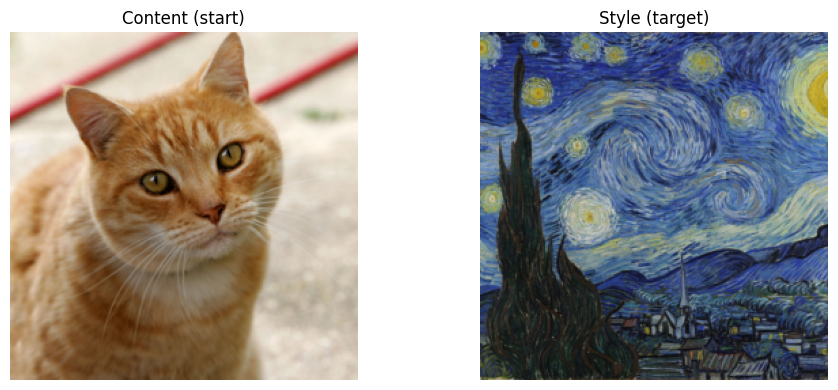

In [27]:
CONTENT_NAME = "disney_1"
STYLE_NAME   = "vangogh_1"

assert CONTENT_NAME in imgs_pil and STYLE_NAME in imgs_pil
print("Content:", CONTENT_NAME, "| Style:", STYLE_NAME)

content_img = to_tensor_01(imgs_pil[CONTENT_NAME]).unsqueeze(0).to(device)
style_img   = to_tensor_01(imgs_pil[STYLE_NAME]).unsqueeze(0).to(device)

with torch.no_grad():
    content_act_tgt = extract_acts(content_img, [CONTENT_LID])[CONTENT_LID].detach()
    style_acts = extract_acts(style_img, STYLE_LIDS)
    style_grams_tgt = {lid: gram_matrix(style_acts[lid]).detach() for lid in STYLE_LIDS}

# sanity
assert_tensor(content_act_tgt, ndim=4, name="content_act_tgt")
for lid in STYLE_LIDS:
    G = style_grams_tgt[lid]
    assert_tensor(G, ndim=2, name=f"style_gram_tgt[{lid}]")
    assert G.shape[0] == G.shape[1]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); show_image(content_img[0].detach().cpu(), "Content (start)")
plt.subplot(1,2,2); show_image(style_img[0].detach().cpu(), "Style (target)")
plt.tight_layout(); plt.show()


In [28]:
def content_loss(act: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return torch.mean((act - target) ** 2)

def style_loss(acts: dict, grams_tgt: dict, style_lids, layer_weights=None) -> torch.Tensor:
    if layer_weights is None:
        layer_weights = {lid: 1.0 for lid in style_lids}
    loss = 0.0
    for lid in style_lids:
        G = gram_matrix(acts[lid])
        loss = loss + layer_weights[lid] * torch.mean((G - grams_tgt[lid]) ** 2)
    return loss

# ALPHA = 1.0   # content weight
# BETA  = 5e3   # style weight (typically much larger)

ALPHA = 5.0 # content weight
BETA  = 2e3 # style weight (typically much larger)

assert ALPHA > 0 and BETA > 0


Lc: 0.0 Ls: 0.0002092183131026104 L: 0.41843661665916443
grad_mag min/max: 9.053393910107843e-07 0.0011486744042485952


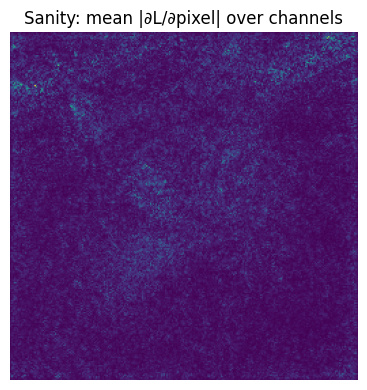

In [29]:
x = content_img.clone().detach().requires_grad_(True)

acts_x = extract_acts(x, set([CONTENT_LID] + STYLE_LIDS))
Lc = content_loss(acts_x[CONTENT_LID], content_act_tgt)
Ls = style_loss(acts_x, style_grams_tgt, STYLE_LIDS)
L  = ALPHA * Lc + BETA * Ls

L.backward()

assert x.grad is not None
assert_tensor(x.grad, ndim=4, name="x.grad")

grad_mag = x.grad[0].abs().mean(dim=0).detach().cpu()  # (H,W)
assert grad_mag.ndim == 2 and torch.isfinite(grad_mag).all().item()

print("Lc:", float(Lc.detach().cpu()), "Ls:", float(Ls.detach().cpu()), "L:", float(L.detach().cpu()))
print("grad_mag min/max:", float(grad_mag.min()), float(grad_mag.max()))

plt.figure(figsize=(5,4))
plt.imshow(grad_mag)
plt.title("Sanity: mean |∂L/∂pixel| over channels")
plt.axis("off")
plt.tight_layout()
plt.show()


Baseline L0: 0.41843661665916443
step_size=  1.0:  L1=0.435459  
step_size=  0.5:  L1=0.422211  
step_size=  0.2:  L1=0.418746  
step_size=  0.1:  L1=0.418392  ✅
step_size= 0.05:  L1=0.418366  ✅
step_size= 0.02:  L1=0.418397  ✅
step_size= 0.01:  L1=0.418416  ✅

Best step_size: 0.05 Best L1: 0.4183655083179474


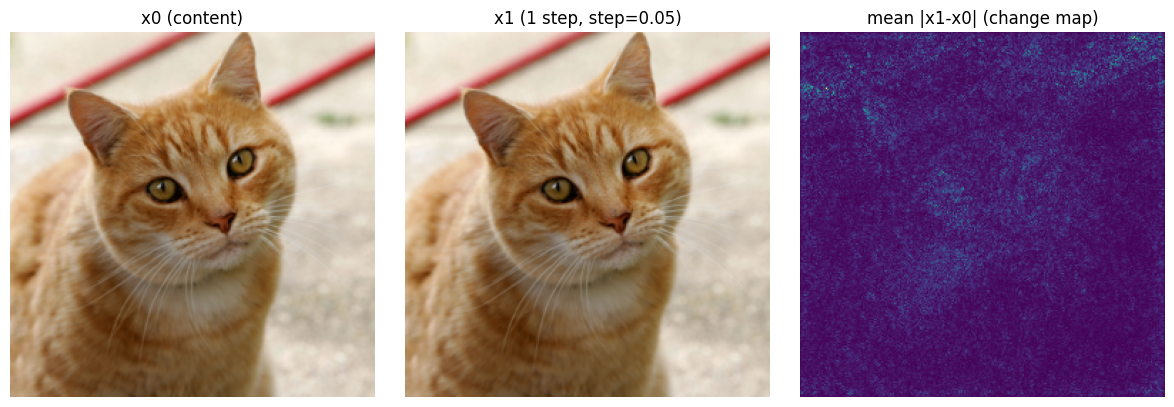

In [30]:
# Robust one-step sanity: try multiple step sizes and pick one that decreases loss

x0 = content_img.clone().detach()
x  = x0.clone().detach().requires_grad_(True)

acts_x = extract_acts(x, set([CONTENT_LID] + STYLE_LIDS))
Lc0 = content_loss(acts_x[CONTENT_LID], content_act_tgt)
Ls0 = style_loss(acts_x, style_grams_tgt, STYLE_LIDS)
L0  = ALPHA*Lc0 + BETA*Ls0
L0.backward()

step_sizes = [1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
results = []

with torch.no_grad():
    for s in step_sizes:
        x1 = (x0 - s * x.grad).clamp(0.0, 1.0)
        acts_1 = extract_acts(x1, set([CONTENT_LID] + STYLE_LIDS))
        Lc1 = content_loss(acts_1[CONTENT_LID], content_act_tgt)
        Ls1 = style_loss(acts_1, style_grams_tgt, STYLE_LIDS)
        L1  = ALPHA*Lc1 + BETA*Ls1
        results.append((s, float(L1.detach().cpu())))

print("Baseline L0:", float(L0.detach().cpu()))
for s, L1 in results:
    print(f"step_size={s:>5}:  L1={L1:.6f}  {'✅' if L1 < float(L0.detach().cpu()) else ''}")

# Show best
best_s, best_L1 = min(results, key=lambda t: t[1])
print("\nBest step_size:", best_s, "Best L1:", best_L1)

# Visualize best step result
with torch.no_grad():
    x_best = (x0 - best_s * x.grad).clamp(0.0, 1.0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); show_image(x0[0].cpu(), "x0 (content)")
plt.subplot(1,3,2); show_image(x_best[0].cpu(), f"x1 (1 step, step={best_s})")
plt.subplot(1,3,3)
plt.imshow((x_best[0]-x0[0]).abs().mean(0).cpu())
plt.title("mean |x1-x0| (change map)")
plt.axis("off")
plt.tight_layout()
plt.show()


# Training Cell:

In [31]:
from tqdm.auto import tqdm
import numpy as np
import torch

# -----------------------------
# Hyperparameters (shown in your UI status panel)
# -----------------------------
STEPS_A = 40
STEPS_B = 90
STEPS_C = 160
milestones = [STEPS_A,STEPS_B,STEPS_C]
NUM_STEPS = STEPS_A + STEPS_B + STEPS_C
# IMPORTANT: Adam LR is NOT the same as the one-step GD best_s
LR = 0.1 #0.02

# Stage A (structure first)
ALPHA_A, BETA_A = 10.0, 600.0

# Stage B (paint later)
ALPHA_B, BETA_B = 2.0, 4500.0

# Style layer weights (must match STYLE_LIDS)
# STYLE_LAYER_WEIGHTS = {1: 1.0, 6: 0.8, 11: 0.5}

# Total variation weight (removes speckle)
TV_W = 2e-2

# Save snapshots
SAVE_EVERY = 10

# -----------------------------
# Sanity checks (catch drift early)
# -----------------------------
assert isinstance(STYLE_LIDS, (list, tuple)) and len(STYLE_LIDS) > 0
assert set(STYLE_LIDS) == set(STYLE_LAYER_WEIGHTS.keys()), (
    f"STYLE_LIDS={STYLE_LIDS} must match STYLE_LAYER_WEIGHTS keys={list(STYLE_LAYER_WEIGHTS.keys())}"
)

# Quick activation sanity (ensure these layers are actually extracted)
x_test = to_tensor_01(imgs_pil["disney_1"]).unsqueeze(0).to(device)
acts_test = extract_acts(x_test, set([CONTENT_LID] + list(STYLE_LIDS)))
assert set([CONTENT_LID] + list(STYLE_LIDS)).issubset(set(acts_test.keys())), (
    f"Missing acts keys. Have={sorted(acts_test.keys())}"
)

print("✅ Sanity OK")
print("CONTENT_LID:", CONTENT_LID, "STYLE_LIDS:", STYLE_LIDS)
print("Schedule A:", (ALPHA_A, BETA_A), "Schedule B:", (ALPHA_B, BETA_B))
print("TV_W:", TV_W, "Adam LR:", LR, "NUM_STEPS:", NUM_STEPS)

# -----------------------------
# TV loss
# -----------------------------
def total_variation_loss(x01: torch.Tensor) -> torch.Tensor:
    # x01: (1,3,H,W)
    assert_tensor(x01, ndim=4, name="x01")
    dh = torch.mean(torch.abs(x01[:, :, 1:, :] - x01[:, :, :-1, :]))
    dw = torch.mean(torch.abs(x01[:, :, :, 1:] - x01[:, :, :, :-1]))
    return dh + dw

# -----------------------------
# Compute loss (returns components)
# -----------------------------
def compute_losses(x01, *, alpha, beta):
    acts = extract_acts(x01, set([CONTENT_LID] + list(STYLE_LIDS)))
    Lc = content_loss(acts[CONTENT_LID], content_act_tgt)
    Ls = style_loss(acts, style_grams_tgt, STYLE_LIDS, layer_weights=STYLE_LAYER_WEIGHTS)
    Ltv = total_variation_loss(x01)
    L = alpha * Lc + beta * Ls + TV_W * Ltv
    return L, Lc, Ls, Ltv

# -----------------------------
# Optimization
# -----------------------------
x_opt = content_img.clone().detach().to(device).requires_grad_(True)
opt = torch.optim.Adam([x_opt], lr=LR)

# LR schedule: step-down at boundary + mid-stage-B polish
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    opt,
    milestones=milestones,
    gamma=0.3
)

snapshots = []
loss_log = []  # [step, total, content, style, tv, alpha, beta, lr]

pbar = tqdm(range(1, NUM_STEPS + 1), desc="Optimizing pixels", leave=True)

for step in pbar:
    if step <= STEPS_A:
        alpha, beta = ALPHA_A, BETA_A
        stage = "A"
    else:
        alpha, beta = ALPHA_B, BETA_B
        stage = "B"

    opt.zero_grad(set_to_none=True)
    L, Lc, Ls, Ltv = compute_losses(x_opt, alpha=alpha, beta=beta)
    L.backward()
    opt.step()

    # Clamp to valid image range
    with torch.no_grad():
        x_opt.clamp_(0.0, 1.0)

    # Scheduler step AFTER opt.step (good practice)
    scheduler.step()
    current_lr = opt.param_groups[0]["lr"]

    row = [
        step,
        float(L.detach().cpu()),
        float(Lc.detach().cpu()),
        float(Ls.detach().cpu()),
        float(Ltv.detach().cpu()),
        float(alpha),
        float(beta),
        float(current_lr),
    ]
    loss_log.append(row)

    if step % 5 == 0 or step in (1, NUM_STEPS):
        pbar.set_postfix({
            "stage": stage,
            "lr": f"{current_lr:.5f}",
            "L": f"{row[1]:.4f}",
            "Lc": f"{row[2]:.4f}",
            "Ls": f"{row[3]:.4f}",
            "TV": f"{row[4]:.4f}",
        })

    if step % SAVE_EVERY == 0 or step in (1, NUM_STEPS):
        snapshots.append(x_opt.detach().cpu()[0].clone())

# Final sanity
assert len(snapshots) >= 2
loss_log_np = np.array(loss_log, dtype=np.float32)
assert np.isfinite(loss_log_np).all()

print("✅ Morph complete.")
print("Stored snapshots:", len(snapshots))
print("Final row:", loss_log[-1])


✅ Sanity OK
CONTENT_LID: 20 STYLE_LIDS: [1, 6, 11, 20]
Schedule A: (10.0, 600.0) Schedule B: (2.0, 4500.0)
TV_W: 0.02 Adam LR: 0.1 NUM_STEPS: 290


Optimizing pixels:   0%|          | 0/290 [00:00<?, ?it/s]

✅ Morph complete.
Stored snapshots: 30
Final row: [290, 1.9331517219543457, 0.5634256601333618, 0.00017769300029613078, 0.3340972065925598, 2.0, 4500.0, 0.0026999999999999997]


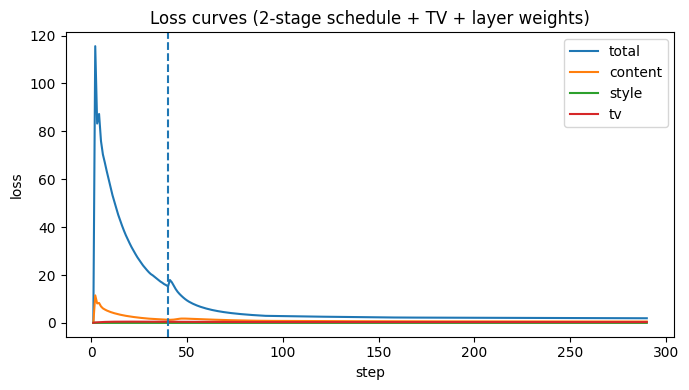

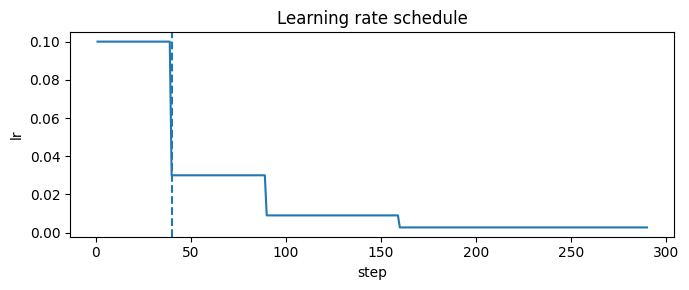

In [32]:
import matplotlib.pyplot as plt
import numpy as np

assert "loss_log_np" in globals()
assert loss_log_np.ndim == 2

ncols = loss_log_np.shape[1]
assert ncols in (7, 8), f"Expected 7 or 8 cols, got {ncols}. shape={loss_log_np.shape}"

steps = loss_log_np[:, 0]
Ltot  = loss_log_np[:, 1]
Lc    = loss_log_np[:, 2]
Ls    = loss_log_np[:, 3]
Ltv   = loss_log_np[:, 4]

plt.figure(figsize=(7,4))
plt.plot(steps, Ltot, label="total")
plt.plot(steps, Lc,   label="content")
plt.plot(steps, Ls,   label="style")
plt.plot(steps, Ltv,  label="tv")

# mark stage boundary if available
if "STEPS_A" in globals():
    plt.axvline(STEPS_A, linestyle="--")

plt.title("Loss curves (2-stage schedule + TV + layer weights)")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot LR if present
if ncols == 8:
    lr = loss_log_np[:, 7]
    plt.figure(figsize=(7,3))
    plt.plot(steps, lr, label="lr")
    if "STEPS_A" in globals():
        plt.axvline(STEPS_A, linestyle="--")
    plt.title("Learning rate schedule")
    plt.xlabel("step")
    plt.ylabel("lr")
    plt.tight_layout()
    plt.show()

# Sanity
if "NUM_STEPS" in globals():
    assert len(steps) == NUM_STEPS


In [33]:
max_idx = len(snapshots) - 1
assert max_idx >= 1

idx_slider = widgets.IntSlider(
    value=0, min=0, max=max_idx, step=1,
    description="snapshot index",
    style=SLIDER_STYLE, layout=SLIDER_LAYOUT,
)

show_diff = widgets.Checkbox(value=True, description="show diff map", indent=False)

# --- NEW: a small HTML "status panel" with hyperparams ---
def _fmt_layers(lids):
    return "[" + ", ".join(str(x) for x in lids) + "]"

def _fmt_dict(d):
    if not isinstance(d, dict) or len(d) == 0:
        return "unknown"
    # compact "k:v" pairs
    items = []
    for k in sorted(d.keys()):
        items.append(f"{k}:{d[k]}")
    return "{" + ", ".join(items) + "}"

def _status_html():
    g = globals()

    # Core experiment identity
    content_name = g.get("CONTENT_NAME", "unknown")
    style_name   = g.get("STYLE_NAME", "unknown")
    img_size     = g.get("IMG_SIZE", "unknown")

    # Model/layers
    content_lid  = g.get("CONTENT_LID", "unknown")
    style_lids   = g.get("STYLE_LIDS", [])
    style_w      = g.get("STYLE_LAYER_WEIGHTS", g.get("STYLE_LAYER_WEIGHTS", {}))

    # Optimizer / run length
    lr           = g.get("LR", "unknown")
    num_steps    = g.get("NUM_STEPS", "unknown")
    save_every   = g.get("SAVE_EVERY", "unknown")

    # Single-stage (fallback if you still run older code sometimes)
    alpha = g.get("ALPHA", None)
    beta  = g.get("BETA", None)

    # Two-stage schedule
    steps_a = g.get("STEPS_A", None)
    steps_b = g.get("STEPS_B", None)
    alpha_a = g.get("ALPHA_A", None)
    beta_a  = g.get("BETA_A", None)
    alpha_b = g.get("ALPHA_B", None)
    beta_b  = g.get("BETA_B", None)

    # Regularization
    tv_w = g.get("TV_W", None)

    # Helper strings
    style_lids_str = _fmt_layers(style_lids) if isinstance(style_lids, (list, tuple)) else "unknown"
    style_w_str    = _fmt_dict(style_w)

    # Decide what to display for schedule
    has_2stage = (steps_a is not None) and (steps_b is not None) and (alpha_a is not None) and (beta_a is not None) and (alpha_b is not None) and (beta_b is not None)

    if has_2stage:
        schedule_html = f"""
        <div><b>Schedule</b></div><div>2-stage (A then B)</div>
        <div><b>Stage A</b></div><div>steps={steps_a}, α={alpha_a}, β={beta_a}</div>
        <div><b>Stage B</b></div><div>steps={steps_b}, α={alpha_b}, β={beta_b}</div>
        """
    else:
        # fallback to single-stage if present
        a_str = "unknown" if alpha is None else alpha
        b_str = "unknown" if beta  is None else beta
        schedule_html = f"""
        <div><b>Schedule</b></div><div>single-stage</div>
        <div><b>ALPHA (content)</b></div><div>{a_str}</div>
        <div><b>BETA (style)</b></div><div>{b_str}</div>
        """

    tv_str = "unknown" if tv_w is None else tv_w

    return f"""
    <div style="font-family: Arial, sans-serif; line-height: 1.35; padding: 10px 12px; border: 1px solid #ddd; border-radius: 10px;">
      <div style="font-size: 14px; font-weight: 700; margin-bottom: 8px;">
        Style Transfer Morph — Experiment Settings
      </div>

      <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 12px;">
        <!-- Left column -->
        <div style="display: grid; grid-template-columns: 160px 1fr; gap: 3px 10px; font-size: 13px;">
          <div><b>Content image</b></div><div>{content_name}</div>
          <div><b>Style image</b></div><div>{style_name}</div>
          <div><b>Image size</b></div><div>{img_size} × {img_size}</div>

          <div><b>Content layer</b></div><div>{content_lid}</div>
          <div><b>Style layers</b></div><div>{style_lids_str}</div>
          <div><b>Layer weights</b></div><div>{style_w_str}</div>
        </div>

        <!-- Right column -->
        <div style="display: grid; grid-template-columns: 160px 1fr; gap: 3px 10px; font-size: 13px;">
          <div><b>Adam LR</b></div><div>{lr}</div>
          <div><b>NUM_STEPS</b></div><div>{num_steps}</div>
          <div><b>SAVE_EVERY</b></div><div>{save_every}</div>

          {schedule_html}

          <div><b>TV_W</b></div><div>{tv_str}</div>
        </div>
      </div>

      <div style="margin-top: 8px; font-size: 12px; color: #555;">
        Tip: scrub snapshots with the slider. Toggle “show diff map” to see where pixels changed most.
      </div>
    </div>
    """

status_box = widgets.HTML(value=_status_html())

def render(idx, show_diff=True):
    img = snapshots[idx]

    # Approximate step number for this snapshot
    if idx == 0:
        step_approx = 1
    elif idx == max_idx:
        step_approx = NUM_STEPS
    else:
        step_approx = idx * SAVE_EVERY

    # --- Header + images ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    show_image(content_img[0].detach().cpu(), "content (start)")

    plt.subplot(1,3,2)
    show_image(img, f"optimized (≈ step {step_approx})")

    plt.subplot(1,3,3)
    if show_diff:
        diff = (img - content_img[0].detach().cpu()).abs().mean(0)
        plt.imshow(diff)
        plt.title("mean |x - content|")
        plt.axis("off")
    else:
        show_image(style_img[0].detach().cpu(), "style (target)")

    plt.tight_layout()
    plt.show()

ui = widgets.VBox([
    status_box,
    widgets.HBox([idx_slider, show_diff])
])

out = widgets.interactive_output(render, {"idx": idx_slider, "show_diff": show_diff})
display(ui, out)

# Sanity
assert max_idx >= 1


Output()